<a href="https://colab.research.google.com/github/okcy58/AI2022/blob/main/RNN%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EB%A5%98(Text_Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.케라스를 이용한 텍스트 분류 개요(Text Classification using Keras)
- 텍스트 분류(Text Classification): 텍스트를 입력으로 받아 텍스트가 어떤 종류의 범주에 속하는지를 구분하는 작업
- 스팸 메일 분류, 감성 분석, 의도 분석

## 1.1 훈련 데이터에 대한 이해
- 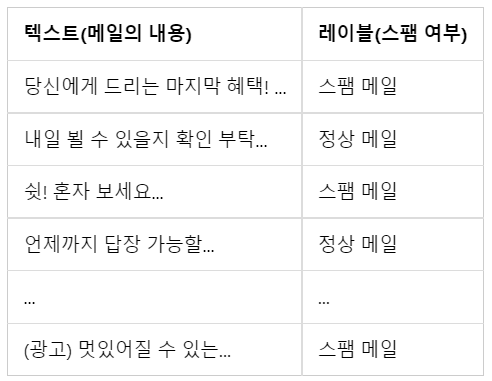

- 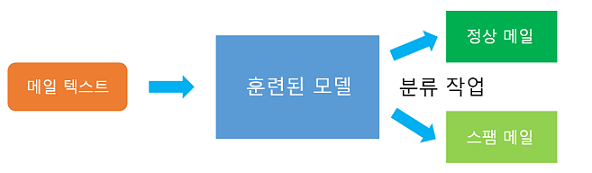


## 1.2 훈련 데이터와 테스트 데이터
- 훈련 데이터 (X_train, y_train)
- 테스트 데이터 (X_test, y_test)


## 1.3 단어에 대한 정수 부여
- 케라스의 Embedding(): 단어 각각에 대해 정수로 변환된 입력에 대해서 임베딩
- 단어를 빈도수 순대로 정렬하고 순차적으로 정수를 부여 => 저빈도 단어 제거




## 1.4 RNN으로 분류하기
- model.add(SimpleRNN(hidden_units, input_shape=(timesteps, input_dim)))
  - hidden_units = RNN의 출력의 크기 = 은닉 상태의 크기.
  - timesteps = 시점의 수 = 각 문서에서의 단어 수.
  - input_dim = 입력의 크기 = 임베딩 벡터의 차원.

## 1.5 RNN의 다-대-일(Many-to-One) 문제
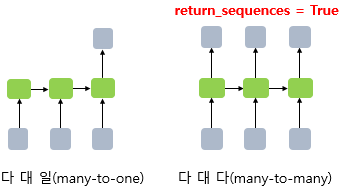
- 텍스트 분류는 모든 시점(time step)에 대해서 입력을 받지만 최종 시점의 RNN 셀만이 은닉 상태를 출력하고, 이것이 출력층으로 가서 활성화 함수를 통해 정답을 고르는 문제
- 이진분류: 다 대 일
  - 출력층의 활성화 함수: 시그모이드 함수
  - 손실 함수: binary_crossentropy
- 다중 분류: 다 대 다
  - 출력층의 활성화 함수: 소프트맥스 함수
  - 손실 함수: categorical_crossentropy

# 2.스팸 메일 분류하기(Spam Detection)


## 2.1 스팸 메일 데이터에 대한 이해
- 다운로드 링크 : https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

- 다운로드 받은 spam.csv 파일을 데이터프레임으로 로드하고 총 샘플의 수를 확인

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin1')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [3]:
# 상위  5개의 행만 출력
data[:5]

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
# 불피요한 열(Unnamed) 제거
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
# v1 열에서 정상메일('ham'), 스팸메일('spam')dmf 0과 1로 구분
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
data[:5]

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [5]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : True


In [6]:
print('v2열의 유니크한 값 :',data['v2'].nunique())

v2열의 유니크한 값 : 5169


In [7]:
# v2 열에서 중복인 내용이 있다면 중복 제거 (403개의 중복 샘플이 존재)
data.drop_duplicates(subset=['v2'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5169


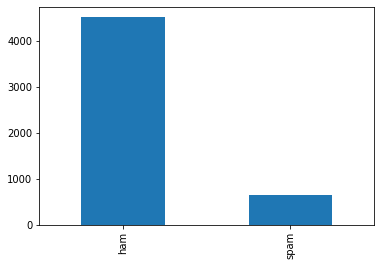

In [8]:
# 레이블 값의 분포를 시각화
data['v1'].value_counts().plot(kind='bar')

In [13]:
print('정상 메일과 스팸 메일의 개수')
print(data.groupby('v1').size())
print(data.groupby('v1').size().reset_index(name='count'))

정상 메일과 스팸 메일의 개수
v1
ham     4516
spam     653
dtype: int64
     v1  count
0   ham   4516
1  spam    653


In [14]:
print(f'정상 메일의 비율 = {round(data["v1"].value_counts()[0]/len(data) * 100,3)}%')
print(f'스팸 메일의 비율 = {round(data["v1"].value_counts()[1]/len(data) * 100,3)}%')

정상 메일의 비율 = 87.367%
스팸 메일의 비율 = 12.633%


In [15]:
# v2열과 v1열을 X데이터와 y데이터라는 X_data, y_data로 저장
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


In [16]:
# 훈련 데이터와 테스트 데이터를 분리
# 레이블이 불균형한 경우에는 데이터를 나눌 때에도 훈련 데이터와 테스트 데이터에 각 레이블의 분포가 고르게 분포되도록 하는 것이 중요
# stratify의 인자
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [17]:
print('--------훈련 데이터의 비율-----------')
print(f'정상 메일 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'스팸 메일 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
정상 메일 = 87.376%
스팸 메일 = 12.624%


In [18]:
print('--------테스트 데이터의 비율-----------')
print(f'정상 메일 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'스팸 메일 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
정상 메일 = 87.331%
스팸 메일 = 12.669%


- tokenizer.fit_on_texts(X_train): 훈련 데이터에 대해서 토큰화
- X_train_encoded: 훈련 데이터에 대해서 정수 인코딩

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)
print(X_train_encoded[:5])

[[102, 1, 210, 230, 3, 17, 39], [1, 59, 8, 427, 17, 5, 137, 2, 2326], [157, 180, 12, 13, 98, 93, 47, 9, 40, 3485, 247, 8, 7, 87, 6, 80, 1312, 5, 3486, 7, 2327, 11, 660, 306, 20, 25, 467, 708, 1028, 203, 129, 193, 800, 2328, 23, 1, 144, 71, 2, 111, 78, 43, 2, 130, 11, 800, 186, 122, 1512], [1, 1154, 13, 104, 292], [222, 622, 857, 540, 623, 22, 23, 83, 10, 47, 6, 257, 32, 6, 26, 64, 936, 407]]


In [20]:
# 각 정수에 어떤 단어가 부여되었는지 확인
word_to_index = tokenizer.word_index
print(word_to_index)

{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'it': 14, 'of': 15, 'have': 16, 'on': 17, 'call': 18, 'that': 19, 'are': 20, '2': 21, 'now': 22, 'so': 23, 'but': 24, 'not': 25, 'can': 26, 'or': 27, "i'm": 28, 'get': 29, 'at': 30, 'do': 31, 'if': 32, 'be': 33, 'will': 34, 'just': 35, 'with': 36, 'we': 37, 'no': 38, 'this': 39, 'ur': 40, 'up': 41, '4': 42, 'how': 43, 'gt': 44, 'lt': 45, 'go': 46, 'when': 47, 'from': 48, 'what': 49, 'ok': 50, 'out': 51, 'know': 52, 'free': 53, 'all': 54, 'like': 55, 'then': 56, 'got': 57, 'good': 58, 'am': 59, 'time': 60, 'was': 61, 'come': 62, 'its': 63, 'love': 64, 'want': 65, 'text': 66, 'he': 67, 'only': 68, 'there': 69, 'day': 70, 'need': 71, 'going': 72, 'lor': 73, 'send': 74, 'one': 75, 'as': 76, 'home': 77, 'about': 78, 'back': 79, 'still': 80, 'k': 81, 'see': 82, 'txt': 83, 'by': 84, 'da': 85, 'stop': 86, 'r': 87, 'any': 88, 'tell': 89, 'dont': 90, "i'll": 91, "don't": 9

In [21]:
# 각 단어에 대한 등장 빈도수
tokenizer.word_counts.items()

odict_items([('sorry', 101), ('i', 1832), ("can't", 47), ('help', 44), ('you', 1644), ('on', 404), ('this', 258), ('am', 171), ('in', 664), ('bus', 22), ('the', 1003), ('way', 75), ('to', 1679), ('calicut', 2), ('thanks', 65), ('again', 55), ('for', 525), ('your', 519), ('reply', 105), ('today', 108), ('when', 221), ('is', 643), ('ur', 256), ('visa', 1), ('coming', 41), ('and', 754), ('r', 113), ('u', 859), ('still', 125), ('buying', 5), ('gucci', 1), ('bags', 2), ('my', 551), ('sister', 13), ('things', 31), ('are', 383), ('not', 336), ('easy', 20), ('uncle', 12), ('john', 7), ('also', 48), ('has', 79), ('his', 50), ('own', 10), ('bills', 2), ('so', 353), ('really', 71), ('need', 142), ('think', 93), ('about', 126), ('how', 235), ('make', 79), ('money', 52), ('later', 84), ('sha', 4), ('liked', 6), ('new', 100), ('house', 33), ('hello', 45), ('darlin', 14), ('ive', 9), ('finished', 17), ('college', 14), ('now', 360), ('txt', 119), ('me', 614), ('finish', 39), ('if', 297), ('can', 326),

- 전체 훈련 데이터에서 등장 빈도로 얼만큼의 비율을 차지

In [22]:
threshold = 2
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 4337
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.45326684567191
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.65745644331875


- 등장 빈도가 지나치게 낮은 단어들은 자연어 처리에서 제외: 
- tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)

In [24]:
vocab_size = len(word_to_index) + 1  # 패딩을 위한 0번 단어를 고려하여 +1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 7822


메일의 최대 길이 : 189
메일의 평균 길이 : 15.754534


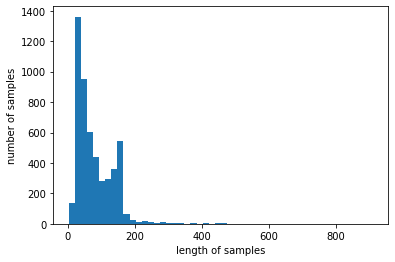

In [29]:
print('메일의 최대 길이 : %d' % max(len(sample) for sample in X_train_encoded))
print('메일의 평균 길이 : %f' % (sum(map(len, X_train_encoded))/len(X_train_encoded)))
plt.hist([len(sample) for sample in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
max_len = 162
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)
print("훈련 데이터의 크기(shape):", X_train_padded.shape)

훈련 데이터의 크기(shape): (4135, 162)


## 2.2. RNN으로 스팸 메일 분류하기

In [35]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

embedding_dim = 32
hidden_units = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_padded, y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4


UnimplementedError: ignored

In [ ]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test_padded, y_test)[1]))

35/35 [==============================] - 0s 9ms/step - loss: 0.0794 - acc: 0.9785

 테스트 정확도: 0.9785


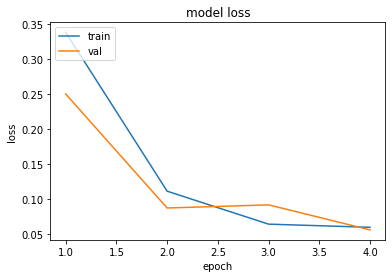

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 3. 로이터 뉴스 분류하기(Reuters News Classification)